# Lasso Regression and Coordinate Descent

## Introduction

I am going to give some short analysis on lasso regression and implement the coordinate descent method to solve lasso regression. For experimental purpose, a small dataset with known parameters will be constructed that helps explain why L-1 regularization leads to sparsity.

## I. Data generation

We want to create a design matrix for regression, the size of this dataset is 150, each has 75 features. We will choose a true weight vector $\theta$ such that each sample only has 10 non-zero components:

In [5]:
import numpy

# 1. Design matrix X 
X = numpy.random.rand(150,75)

# 2. Weight vector theta.
#    Set the first 10 component of theta to 10 or -10 arbitrarily and all the other components to zero.
t = [-1,1]
theta_1 = numpy.random.choice(t,10)*10
theta_2 = numpy.zeros(65)
theta = numpy.concatenate((theta_1,theta_2), axis=0)

# 3. Construct a vector y = X theta + epsilon, where epsilon is a random noise vector
epsilon = 0.1*numpy.random.randn(150)
y = numpy.dot(X,theta)+epsilon

# 4. Split the dataset into training/validation/test set
X_train = X[0:80,:]
y_train = y[0:80]
X_valid = X[80:100,:]
y_valid = y[80:100]
X_test = X[100:150,:]
y_test = y[100:150] 

By construction, we know that our dataset admits a sparse solution. 

First, let's run ridge regression first on our dataset and see how it performs.

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def ridge(X, y, Lambda):
    (N,D) = X.shape
    def ridge_obj(theta):
        return ((np.linalg.norm(np.dot(X, theta) - y))**2)/(2*N) + Lambda*(np.linalg.norm(theta))**2
    return ridge_obj


def compute_loss(X, y, Lambda, theta):
    (N,D) = X.shape
    return ((np.linalg.norm(np.dot(X, theta) - y))**2)/(2*N)


def optimize_ridge_reg_parameter(X_train, y_train, X_test, y_test):
    (N,D) = X_train.shape
    min_loss = np.inf
    min_loss_lambda = np.inf
    min_loss_w = np.zeros((D,1))
    losses = []
    sparsity = []
    lambdas = [pow(10, i) for i in range(-10, 7)]
    for Lambda in lambdas:
        w = np.random.rand(D,1)
        w_opt = minimize(ridge(X_train, y_train, Lambda), w)
        loss = compute_loss(X_test, y_test, Lambda, w_opt.x)
        losses.append(loss)
        sparsity.append(compute_sparsity(w_opt.x))
    return losses, sparsity
    
def feature_normalization(train, test):
    # Get the stats
    train_max = train.max(axis=0)
    train_min = train.min(axis=0)
    
    # Delete the features that have constant value
    equal_indicator = (train_max != train_min)
    train = train[:, equal_indicator]
    test = test[:, equal_indicator]
    train_max = train_max[equal_indicator]
    train_min = train_min[equal_indicator]
    
    # Normalize 
    train_normalized = (train - train_min) / (train_max - train_min)
    test_normalized = (test - train_min) / (train_max - train_min)
    
    return train_normalized, test_normalized

def compute_sparsity(w_opt):
    c1 = sum(np.abs(w_opt) < pow(10, -3))
    c2 = sum(np.abs(w_opt) < pow(10, -2))
    c3 = sum(np.abs(w_opt) < pow(10, -1))
    return [c1, c2, c3]

In [64]:
X_train, X_valid = feature_normalization(X_train, X_valid)
losses, spa = optimize_ridge_reg_parameter(X_train, y_train, X_valid, y_valid)

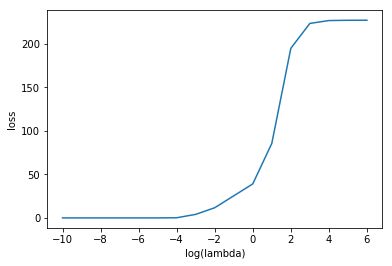

The minimum loss is 0.07000444185776974 at lambda = 1e-05


In [69]:
plt.plot(range(-10, 7), losses)
plt.xlabel('log(lambda)')
plt.ylabel('loss')
plt.show()
min_loss = min(losses)
min_loss_lambda = range(-10, 7)[losses.index(min_loss)]
print("The minimum loss is {} at lambda = {}".format(min_loss, 10 ** min_loss_lambda))

In [66]:
import pandas as pd

sparsity = pd.DataFrame(spa, index=range(-10, 7), columns=['1e-3', '1e-2', '1e-1'])
sparsity.transpose()

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6
10e-3,1,1,1,1,1,0,0,0,0,0,0,0,0,0,75,75,75
10e-2,4,4,4,4,4,2,4,1,0,1,0,0,0,75,75,75,75
10e-1,23,23,23,23,23,25,21,10,11,7,1,0,75,75,75,75,75


We can see from above chart, when using a threshold of $10^{-3}$, most of the true-zero coefficients are treated as non-zero; When $\lambda=10^{-5}$, with threshold $10^{-2}$, there are only 2 zero coefficients, and 25 zero coefficents with threshold $10^{-1}$.

## II. Coordinate Descent for Lasso

The Lasso optimization problem can be formulated as 
$$
\hat{w} = \text{argmin}_{w\in{\mathcal{R}^d}}\sum_{i=1}^{n}(h_w(x_i)-y_i)^2+\lambda\lVert{w}\rVert_1
$$
where $h_w(x) = w^Tx$.

Since L-1 regularization term in the objective function 
is non-differentiable, it's not clear how gradient descent or SGD
could be used to solve this optimization problem. (In fact, subgradient will work and we will see in another notebook.)

Coordinate descent is another approach to solving optimization problems, in which at each step we optimize over only one component of the unknown parameter vector, fixing all other components. 

It turns out that for the Lasso optimization problem, we can find a closed form solution for optimization over a single component fixing all other components, and this gives us the following algorithm, known as the **shooting algorithm** (Murphy, Kevin P. Machine Learning: a probabilistic perspective. MIT press 2012):

### 2.1 Shooting Algorithm
---

$\begin{align*}
&\text{initialize } w = (X^TX+\lambda{I})^{-1}X^Ty;\\
&\text{repeat}\\
&~~~~~~\text{for } j=1,...,D \text{ do}\\
&~~~~~~~~~~~~ a_j = 2\sum x_{ij}^2;\\
&~~~~~~~~~~~~ c_j = 2\sum x_{ij}(y_i-w^Tx_i + w_jx_{ij});\\
&~~~~~~~~~~~~ w_j = soft(\frac{c_j}{a_j}, \frac{\lambda}{a_j});\\
&\text{until } converged;\\
\end{align*}$

---

where the _soft thresholding_ function is defined as

$$soft(\alpha, \delta) = \text{sign}(a)(\lvert{a}\rvert-\delta)_{+}$$


### 2.2 Derive the Coordinate Minimizer for Lasso

In each step of the shooting algorithm, we would like to find the $w_j$ that minimize

$$\begin{align*}
f(w_j) &= \sum_{i=1}^{n}(w^Tx_i - y_i)^2 + \lambda\lvert{w}\rvert_1\\
&= \sum_{i=1}^n{\left[w_jx_{ij}+\sum_{k\neq{j}}w_kx_{ik}-y_i\right]^2} + \lambda\lvert{w_j}\rvert+\lambda\sum_{k\neq{j}}\lvert{w_k}\rvert
\end{align*}$$

where $x_{ij}$ is the $j$-th entry of the vector $x_i$. 

1. For a zero feature, i.e. $x_{ij}=0, i=1,...,n$, the coordinate minimizer $w_j$ is derived by:  
    $$f(w_j)=\sum_{i=1}^n{y_i^2}+\lambda\lvert{w_j}\rvert+\lambda\sum_{k\neq{j}}\lvert{w_k}\rvert$$
    obviously, $w_j=0$ is the coordinate minimizer.
    $$ $$
    
2. When $w_j\neq0$, the derivative of $f(w_j)$ for $w_j$ is  
    $$\begin{align*}f'(w_j)&=2w_j\sum_i{x_{ij}^2}+2\sum_{i}{x_{ij}\left(\sum_{k\neq{j}}w_kx_{ik}-y_i\right)}+\text{sign}(w_j)\lambda\\&=\begin{cases}a_jw_j-c_j+\lambda & w_j>0\\a_jw_j-c_j-\lambda&w_j<0\end{cases}\end{align*}$$
    where
    $$\begin{align*}a_j&=2\sum_{i}{x_{ij}^2}\\c_j&=2\sum_{i}{x_{ij}(y_i-\sum_{k\neq{j}}{w_kx_{ik}})}\end{align*}$$
    therefore, the coordinate minimizer is
    $$w_j^* = \begin{cases}(c_j-\lambda)/a_j&w_j>0\\(c_j+\lambda)/a_j&w_j<0\end{cases}$$
    $$ $$
    
3. So what is the minimizer at $f(0)$:  
    
    $$\begin{cases}f(0^+)=-c_j+\lambda\\f(0^-)=-c_j-\lambda\end{cases}$$
    
    when $c_j\in[-\lambda,\lambda]$, we have $f(0^+)\geq0$ and $f(0^-)\leq0$, which means that $w_j=0$ is the minimizer at $f(0)$.
    
4. In conclusion,  
    
    $$
    w_j = \begin{cases}(c_j-\lambda)/a_j&c_j>\lambda\\
    0&c_j\in[-\lambda,\lambda]\\
    (c_j+\lambda)/a_j&c_j<-\lambda\end{cases}
    $$
    
    which is exactly the update of $w_j$ in shooting algorithm.

### 2.3 Implementation

In [70]:
def shooting_algo(X, y, w, Lambda, tolerance=1e-8, max_iter=10000): 
    # input w is the starting point
    num_instance, num_features = X.shape[0], X.shape[1]
    converged = False
    num_iter = 0
    
    while (~converged)*(num_iter < max_iter):
        w_last = w.copy()
        for j in range(num_features):
            aj = 0
            cj = 0
            for k in range(num_instance):
                aj += X[k,j]**2
                cj += X[k,j] * (y[k] - np.dot(w, X[k]) + w[j] * X[k,j])
            aj *= 2
            cj *= 2
            
            # soft function
            if (cj < -Lambda):
                w[j] = (cj + Lambda) / aj
            elif (cj > Lambda):
                w[j] = (cj - Lambda) / aj
            else:
                w[j] = 0
                
        num_iter += 1
        converged = (np.linalg.norm(w-w_last)) < tolerance
    print("\nIter number:", num_iter)    
    return w

In [71]:
def soft(a, delta):
    var_1 = abs(a) - delta
    var_2 = np.max([var_1, 0.])
    var_3 = np.sign(a)*var_2
    return var_3

def compute_square_loss(X, y, theta):
    loss = 0
    m = X.shape[0]
    vector = np.dot(X, theta) - y
    loss = float(np.dot(vector, vector))/(2*m)
    return loss

def Lasso_Shooting(X, y, theta_0, lambda_reg = 1., num_iter = 1000):
    theta = np.zeros(theta_0.shape)
    theta[0: len(theta)] = theta_0
    d = X.shape[1]
    times = 0
    loss = compute_square_loss(X, y, theta)
    loss_change = 1.
    while (loss_change>1e-6) and (times<num_iter):
        loss_old = loss
        for j in range(d):
            X_d = X[:, j]
            a = np.dot(X_d.T, X_d)*2
            vector = y - np.dot(X, theta.T) + X_d*theta[j]
            c = np.dot(X_d.T, vector)*2
            theta[j] = soft(c/a, lambda_reg/a)
        times +=1
        loss = compute_square_loss(X, y, theta)
        loss_change = abs(loss - loss_old)
    return theta



Lasso:
General shooting complete regularization path using 2.8884 seconds
When Lambda = 0.01 the test loss is minimized to 0.04433416874169243


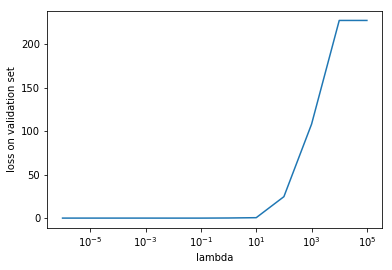

In [87]:
# Lasso shooting
start_1 = time.time()
print("\n\nLasso:")
# pre-search
Lambda_set = np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000,100000])
# zoom-in
# Lambda_set = np.array([1e-6,1e-5,1e-4,3e-4,5e-4,7e-4,9e-4,1e-3,3e-3,5e-3,7e-3,1e-2,2e-2,3e-2,5e-2,7e-2,1e-1])
loss_result = np.zeros(Lambda_set.shape)
sparsity = []
for i in range(Lambda_set.shape[0]):
    # Lambda = 10**i
    Lambda = Lambda_set[i]
    # initialize with ridge estimator
    w_init = np.dot(np.linalg.inv(np.dot(X_train.T, X_train) + Lambda * np.eye(X_train.shape[1])), np.dot(X_train.T, y_train))
    w = Lasso_Shooting(X_train, y_train, w_init, Lambda)
    loss_result[i] = compute_loss(X_valid, y_valid, Lambda, w)
    sparsity.append(compute_sparsity(w))
end_1 = time.time()
print("General shooting completes regularization path using %.4f seconds" % (end_1-start_1))
print("When Lambda = {} the test loss is minimized to {}".format(Lambda_set[loss_result.argmin()], min_loss))
plt.plot(Lambda_set, loss_result)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('loss on validation set')
plt.show()

In [88]:
sparsity = pd.DataFrame(sparsity, index=Lambda_set, columns=['1e-3', '1e-2', '1e-1'])
sparsity.transpose()

,1e-06,1e-05,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0,100000.0
1e-3,2,1,0,0,1,5,20,61,65,68,75,75
1e-2,4,4,4,2,4,10,21,62,65,68,75,75
1e-1,23,23,23,25,31,40,36,62,65,69,75,75


Compared with the result from ridge regression, we can see that lasso regression performs better in terms of sparsity.

## III. Homotopy method


Iter number: 2
Lambda = 100000 loss on valid set is 227.197113828

Iter number: 1
Lambda = 10000.0 loss on valid set is 227.197113828

Iter number: 96
Lambda = 1000.0 loss on valid set is 108.026536494

Iter number: 157
Lambda = 100.0 loss on valid set is 24.7004609486

Iter number: 291
Lambda = 10.0 loss on valid set is 0.562014505656

Iter number: 841
Lambda = 1.0 loss on valid set is 0.0131818373821

Iter number: 2118
Lambda = 0.1 loss on valid set is 0.0124196948372

Iter number: 4313
Lambda = 0.01 loss on valid set is 0.0383524441931

Iter number: 4082
Lambda = 0.001 loss on valid set is 0.0698360114423

Iter number: 2265
Lambda = 0.0001 loss on valid set is 0.0776610368443

Iter number: 119
Lambda = 1e-05 loss on valid set is 0.0777442704541

Iter number: 20
Lambda = 1.0000000000000002e-06 loss on valid set is 0.0777522538926
Homotopy complete regularization path using 227.07992005348206
When Lambda = [ 1.] the test loss is minimized as 0.0124196948372


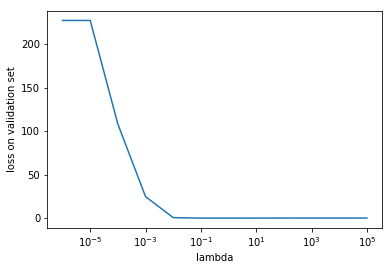

In [89]:
# homotopy method 
start_2 = time.time()
#Lambda_set = np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10])
loss_result = np.zeros(Lambda_set.shape)
sparsity = []
Lambda = 10**5
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train) + Lambda * np.eye(X_train.shape[1])), np.dot(X_train.T, y_train))
    
for i in range(Lambda_set.shape[0]):
    # warm start
    w = shooting_algo(X_train, y_train, w, Lambda, tolerance=1e-5)
    loss_result[i] = compute_loss(X_valid, y_valid, Lambda, w)
    print("Lambda =", Lambda, "loss on valid set is", loss_result[i])
#     report_sparsity(theta, w)
    sparsity.append(compute_sparsity(w))
    Lambda = Lambda / 10
    
end_2 = time.time()
print("Homotopy complete regularization path using", end_2-start_2)
min_loss = loss_result.min()
print("When Lambda =", Lambda_set[loss_result == min_loss], "the test loss is minimized as", min_loss)
plt.plot(Lambda_set, loss_result)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('loss on validation set')
plt.show()

In [21]:
# homotopy method  222
start_4 = time.time()
Lambda_set = np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10])
loss_result = np.zeros(Lambda_set.shape)
Lambda = 10
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train) + Lambda * np.eye(X_train.shape[1])), np.dot(X_train.T, y_train))
    
for i in range(Lambda_set.shape[0]):
    # Lambda = 10**i
    # Lambda = Lambda_set[i]
    #w_init = np.dot(np.linalg.inv(np.dot(X_train.T, X_train) + Lambda * np.eye(X_train.shape[1])), np.dot(X_train.T, y_train))
    #w = shooting_algo(X_train, y_train, w_init, Lambda, tolerance=1e-5)
        
    w = shooting_algo2(X_train, y_train, w, Lambda, tolerance=1e-5)
    loss_result[i] = compute_loss(X_valid, y_valid, Lambda, w)
    print("Lambda =", Lambda, "loss on valid set is", loss_result[i])
    report_sparsity(theta, w)
    Lambda = Lambda / 10
    
end_4 = time.time()
print("Homotopy complete regularization path using", end_4-start_4)
#min_loss = loss_result.min()
#print("When Lambda =", Lambda_set[loss_result == min_loss], "the test loss is minimized as", min_loss)




Iter number: 225
Lambda = 10 loss on valid set is 0.194895889668
Number of true-0 value treated as non-zero is 0
When using threshold 0.001  the number of true-0 treated as non-zero is 0

Iter number: 337
Lambda = 1.0 loss on valid set is 0.00915771311589
Number of true-0 value treated as non-zero is 7
When using threshold 0.001  the number of true-0 treated as non-zero is 6

Iter number: 2831
Lambda = 0.1 loss on valid set is 0.0103138533958
Number of true-0 value treated as non-zero is 46
When using threshold 0.001  the number of true-0 treated as non-zero is 45

Iter number: 2408
Lambda = 0.01 loss on valid set is 0.0374394836143
Number of true-0 value treated as non-zero is 59
When using threshold 0.001  the number of true-0 treated as non-zero is 59

Iter number: 3529
Lambda = 0.001 loss on valid set is 0.0698230270798
Number of true-0 value treated as non-zero is 65
When using threshold 0.001  the number of true-0 treated as non-zero is 65

Iter number: 1506
Lambda = 0.0001 loss

## IV. Vectorization shooting

The algorithm as described above is not ready for a large dataset (at least if it has been implemented in basic Python) because of the implied loop over the dataset (i.e. where we sum over the training set). By using matrix and vector operations, we can eliminate the loops. This is called “vectorization” and can lead to dramatic speedup in languages such as Python, Matlab, and R. Derive matrix expressions for computing $a_j$ and $c_j$.

Now we are going to implement the matrix expressions and measure the speedup in computing the regularization path.

In [26]:
def vectorized_shooting(X, y, w, Lambda, tolerance=1e-8, max_iter=10000): 
    # input w is the starting point
    
    num_instance, num_features = X.shape[0], X.shape[1]
    converged = False
    num_iter = 0
    
    XX2 = 2 * np.dot(X.T, X)  #(num_feat * num_feat)
    Xy2 = 2 * np.dot(X.T, y)  #(num_feat * 1)
    
    while (~converged):#*(num_iter < max_iter):
        w_last = w.copy()
        for j in range(num_features):
            aj = XX2[j,j]
            cj = Xy2[j] - np.dot(XX2[j], w) + XX2[j,j] * w[j]
            
            # soft function
            if (cj < -Lambda):
                w[j] = (cj + Lambda) / aj
            elif (cj > Lambda):
                w[j] = (cj - Lambda) / aj
            else:
                w[j] = 0
                
        num_iter += 1
        converged = (np.linalg.norm(w-w_last)) < tolerance
    print("\nIter number:", num_iter)    
    return w


Iter number: 225
Lambda = 10 loss on valid set is 0.194895889668
Number of true-0 value treated as non-zero is 0
When using threshold 0.001  the number of true-0 treated as non-zero is 0

Iter number: 337
Lambda = 1.0 loss on valid set is 0.00915771311589
Number of true-0 value treated as non-zero is 7
When using threshold 0.001  the number of true-0 treated as non-zero is 6

Iter number: 2831
Lambda = 0.1 loss on valid set is 0.0103138533958
Number of true-0 value treated as non-zero is 46
When using threshold 0.001  the number of true-0 treated as non-zero is 45

Iter number: 2408
Lambda = 0.01 loss on valid set is 0.0374394836143
Number of true-0 value treated as non-zero is 59
When using threshold 0.001  the number of true-0 treated as non-zero is 59

Iter number: 3529
Lambda = 0.001 loss on valid set is 0.0698230270798
Number of true-0 value treated as non-zero is 65
When using threshold 0.001  the number of true-0 treated as non-zero is 65

Iter number: 1506
Lambda = 0.0001 loss

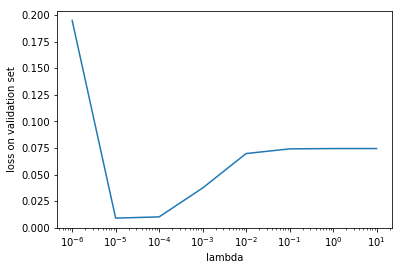

In [24]:
# vectorization shooting 
start_3 = time.time()
Lambda_set = np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10])
loss_result = np.zeros(Lambda_set.shape)
Lambda = 10
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train) + Lambda * np.eye(X_train.shape[1])), np.dot(X_train.T, y_train))
    
for i in range(Lambda_set.shape[0]):
    
    w = vectorized_shooting(X_train, y_train, w, Lambda, tolerance=1e-5)
    loss_result[i] = compute_loss(X_valid, y_valid, Lambda, w)
    print("Lambda =", Lambda, "loss on valid set is", loss_result[i])
    report_sparsity(theta, w)
    Lambda = Lambda / 10
    
end_3 = time.time()
print("Vectorization shooting complete regularization path using", end_3-start_3)
min_loss = loss_result.min()
print("When Lambda =", Lambda_set[loss_result == min_loss], "the test loss is minimized as", min_loss)
plt.plot(Lambda_set, loss_result)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('loss on validation set')
plt.savefig('./output/vector_homotopy_shooting.png', dpi=300)
plt.show()

In [25]:
# test of repeated features
#print(X_train[:,0])
#print(X_train[:,1])

X_corr = X_train.copy()
y_corr = y_train.copy()
print("Original correlation of x1 and x2:", np.corrcoef(X_corr[:,0],X_corr[:,1])[0][1])

X_corr[:,1] = X_corr[:,0] + 1e-2 * np.random.randn(X_corr[:,0].shape[0])
print("With highly correlated x1 and x2:", np.corrcoef(X_corr[:,0],X_corr[:,1])[0][1])
X_covalid = X_valid.copy()
y_covalid = y_valid.copy()

X_covalid[:,1] = X_covalid[:,0] + 1e-2 * np.random.randn(X_covalid[:,0].shape[0])

Lambda = 1000
# init w for lasso regression
w_lasso = np.dot(np.linalg.inv(np.dot(X_corr.T, X_corr) + Lambda * np.eye(X_corr.shape[1])), np.dot(X_corr.T, y_corr))

for i in range(5):
    print("\nLambda =", Lambda)
    
    # init w for ridge regression
    w = np.random.rand(X_corr.shape[1],1)
    w_r = minimize(ridge(X_corr, y_corr, Lambda), w)
    w_ridge = w_r.x
    loss_ridge = compute_loss(X_covalid, y_covalid, Lambda=Lambda, theta=w_ridge)
    
    w_lasso = vectorized_shooting(X_corr, y_corr, w_lasso, Lambda, tolerance=1e-5)
    loss_lasso = compute_loss(X_covalid, y_covalid, Lambda=Lambda, theta=w_lasso)
    print("w of ridge:", w_ridge[:2], "ridge loss =", loss_ridge)
    print("w of lasso:", w_lasso[:2], "lasso loss =", loss_lasso)
    Lambda /= 10 


Original correlation of x1 and x2: -0.162376443064
With highly correlated x1 and x2: 0.999505988474

Lambda = 1000

Iter number: 2
w of ridge: [-0.00179213 -0.0017954 ] ridge loss = 82.0013896428
w of lasso: [ 0.  0.] lasso loss = 82.7096272087

Lambda = 100.0

Iter number: 709
w of ridge: [-0.01614024 -0.01617011] ridge loss = 76.4335761698
w of lasso: [ 0.          2.37954114] lasso loss = 19.035957404

Lambda = 10.0

Iter number: 2961
w of ridge: [-0.06950648 -0.06965893] ridge loss = 54.7666507963
w of lasso: [ 9.07842686  0.        ] lasso loss = 5.36615958154

Lambda = 1.0

Iter number: 39951
w of ridge: [ 0.21839852  0.21832801] ridge loss = 43.1467722037
w of lasso: [ 10.4101305    0.92175515] lasso loss = 8.78162481291

Lambda = 0.1

Iter number: 4957
w of ridge: [ 2.00439005  2.00362686] ridge loss = 32.9580107991
w of lasso: [ 12.12264366   0.        ] lasso loss = 23.0268520445
